# CSC 310 Final Project: Crop Yield Prediction App

Group Members: Ryan Jensen, Timothy Hourihan


## Data Preprocessing

#### Importing necessary libraries

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
import plotly.express as px
# from google.colab import drive # Uncomment if you are running in a Google Colab.

### Reading the Dataset

In [50]:
# Uncomment below if you are running in Google Colab. You should have the dataset stored on your drive. (Note: You can't run Gradio in Google Colab)
# drive.mount('/content/drive')
# df=pd.read_csv("/content/drive/MyDrive/yield_df.csv")

# The following code is if you are running this locally.
df = pd.read_csv("data/yield_df.csv" )

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     28242 non-null  int64  
 1   Area                           28242 non-null  object 
 2   Item                           28242 non-null  object 
 3   Year                           28242 non-null  int64  
 4   hg/ha_yield                    28242 non-null  int64  
 5   average_rain_fall_mm_per_year  28242 non-null  float64
 6   pesticides_tonnes              28242 non-null  float64
 7   avg_temp                       28242 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 1.7+ MB


In [51]:
df.head(10)

,Unnamed: 0,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37
5,5,Albania,Wheat,1990,30197,1485.0,121.0,16.37
6,6,Albania,Maize,1991,29068,1485.0,121.0,15.36
7,7,Albania,Potatoes,1991,77818,1485.0,121.0,15.36
8,8,Albania,"Rice, paddy",1991,28538,1485.0,121.0,15.36
9,9,Albania,Sorghum,1991,6667,1485.0,121.0,15.36


#### Removing the unnamed column

In [52]:
df.drop("Unnamed: 0", axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Area                           28242 non-null  object 
 1   Item                           28242 non-null  object 
 2   Year                           28242 non-null  int64  
 3   hg/ha_yield                    28242 non-null  int64  
 4   average_rain_fall_mm_per_year  28242 non-null  float64
 5   pesticides_tonnes              28242 non-null  float64
 6   avg_temp                       28242 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.5+ MB


#### Changing column names to fit our project

In [53]:
df = df.rename(columns = {"Area":"country"})
df = df.rename(columns = {"Item":"crop"})
df = df.rename(columns = {"Year":"year"})
df.head(10)

,country,crop,year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.0,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37
3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37
5,Albania,Wheat,1990,30197,1485.0,121.0,16.37
6,Albania,Maize,1991,29068,1485.0,121.0,15.36
7,Albania,Potatoes,1991,77818,1485.0,121.0,15.36
8,Albania,"Rice, paddy",1991,28538,1485.0,121.0,15.36
9,Albania,Sorghum,1991,6667,1485.0,121.0,15.36


In [54]:
df.isna().sum(axis=0)

country                          0
crop                             0
year                             0
hg/ha_yield                      0
average_rain_fall_mm_per_year    0
pesticides_tonnes                0
avg_temp                         0
dtype: int64

## Building Model

#### Importing necessary libraries

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

#### Preparing the data for moedeling

In [56]:
# Separating dataset into features and target
X = df.drop('hg/ha_yield', axis=1)
y = df['hg/ha_yield']

# Encoding categorical data
label_encoders = {}
for column in ['country', 'crop']:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Training and evaluating models

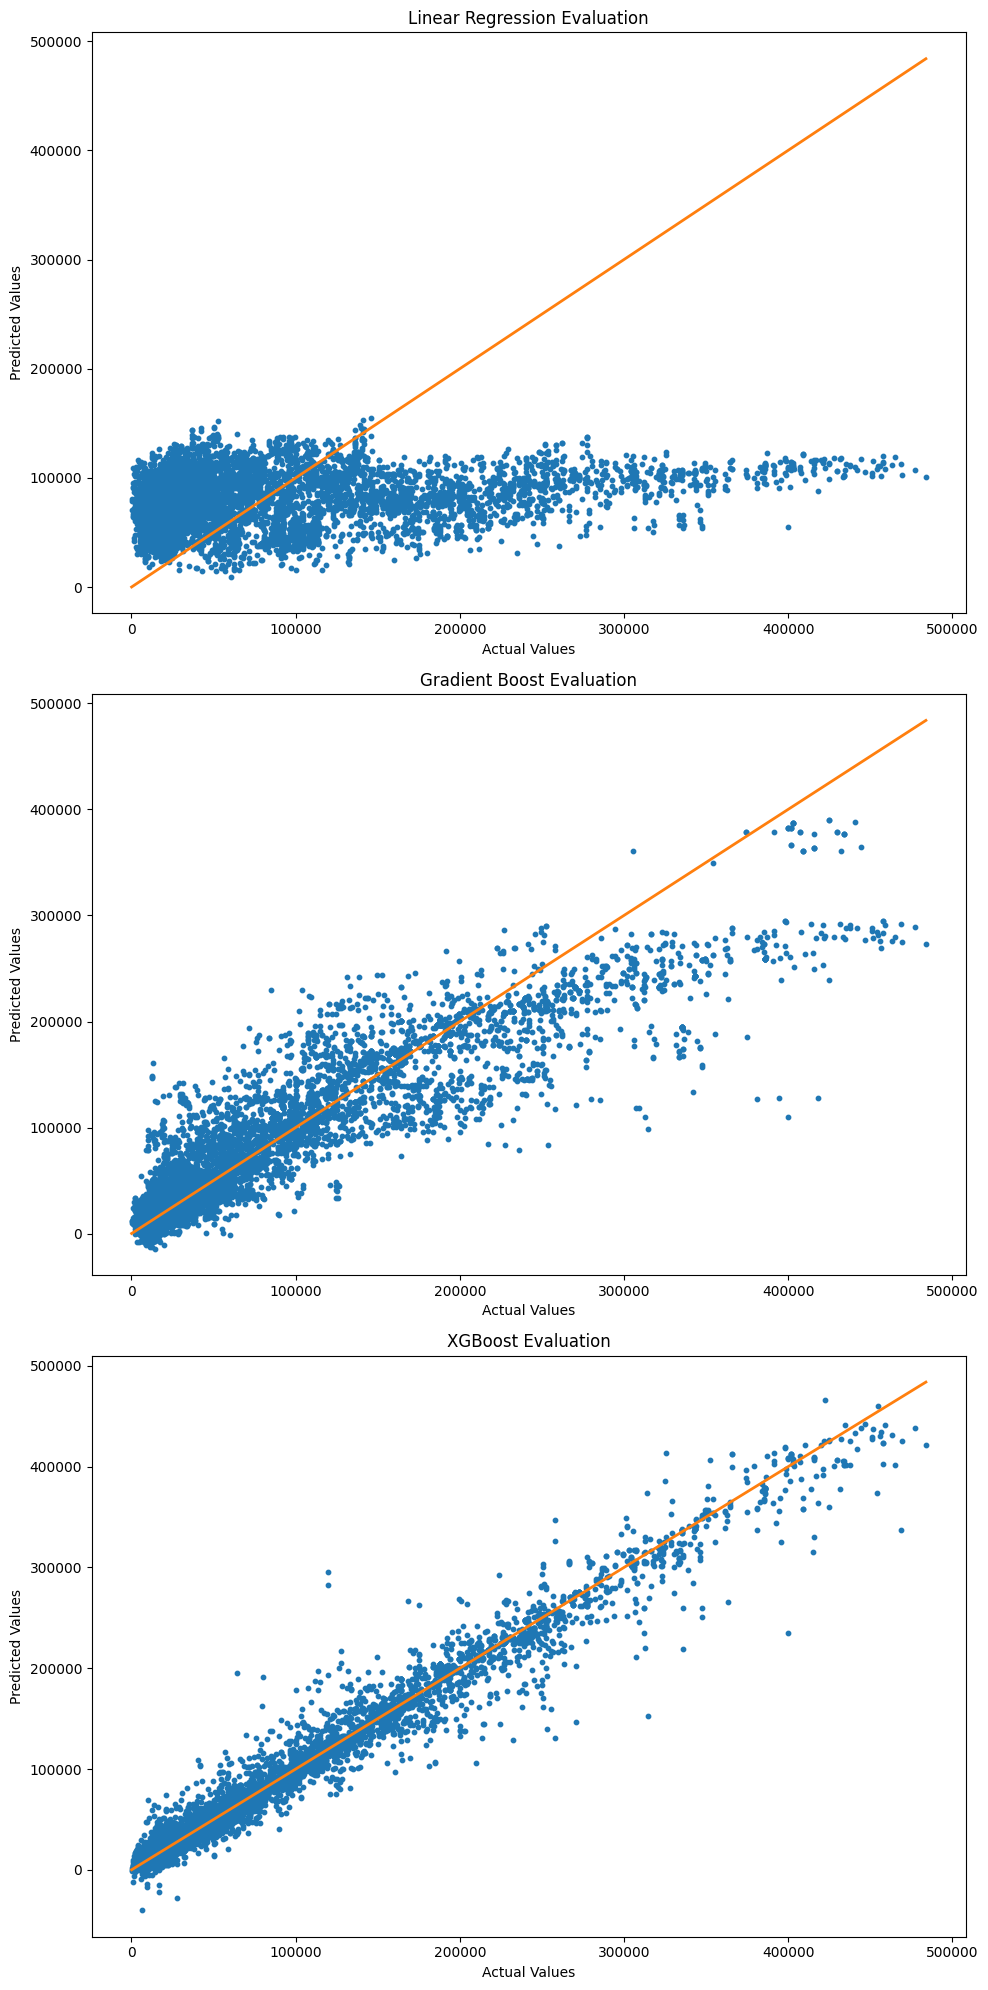

,Model,Accuracy,MSE,R2_score
0,Linear Regression,0.086285,6.772588e+09,0.086285
1,Gradient Boost,0.832376,1.242453e+09,0.832376
2,XGBoost,0.972644,2.027656e+08,0.972644


In [57]:
models = [
    ('Linear Regression', LinearRegression()),
    ('Gradient Boost', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
    ('XGBoost', XGBRegressor(random_state=42)),
]

results = []
fig, axs = plt.subplots(len(models), figsize=(10, 20))

for idx, (name, model) in enumerate(models):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    MSE = mean_squared_error(y_test, y_pred)
    R2_score = r2_score(y_test, y_pred)
    results.append((name, accuracy, MSE, R2_score))

    # Plotting
    axs[idx].scatter(y_test, y_pred, s=10, color='#1f77b4')  # Blue color
    axs[idx].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='#ff7f0e', linewidth=2)  # Orange color
    axs[idx].set_title(f'{name} Evaluation')
    axs[idx].set_xlabel('Actual Values')
    axs[idx].set_ylabel('Predicted Values')

plt.tight_layout()
plt.show()

# Displaying results in a DataFrame
df_results = pd.DataFrame(results, columns=['Model', 'Accuracy', 'MSE', 'R2_score'])
display(df_results)


#### KFold Validation

In [58]:
results = []

models = [
    ('Linear Regression', LinearRegression()),
    ('Gradient Boost', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)),
    ('XGBoost', XGBRegressor(random_state=42)),
    ('KNN', KNeighborsRegressor(n_neighbors=5)),
    ('Decision Tree', DecisionTreeRegressor(random_state=42))
]

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    MSE = mean_squared_error(y_test, y_pred)
    MAE = mean_absolute_error(y_test, y_pred)
    MAPE = mean_absolute_percentage_error(y_test, y_pred)
    R2_score = r2_score(y_test, y_pred)
    results.append((name, accuracy, MSE, MAE, MAPE, R2_score))

    # KFold Validation
    kf = KFold(n_splits=5, shuffle=True)
    scores = cross_val_score(model, X, y, cv=kf)
    mean_score = np.mean(scores)
    print(f"{name} - Mean CV Score: {mean_score}")

Linear Regression - Mean CV Score: 0.08198381113117323
Gradient Boost - Mean CV Score: 0.829476630897813
XGBoost - Mean CV Score: 0.9745285639047904
KNN - Mean CV Score: 0.3169986377852908
Decision Tree - Mean CV Score: 0.9740181053329247


## Model Deployment with Gradio

#### Defining a Predict Function

In [88]:
def predict_yield(crop_type, rainfall, country, pesticides, temperature):
    try:
        # Convert inputs to the correct data types
        rainfall = float(rainfall)
        pesticides = float(pesticides)
        temperature = float(temperature)

        # Apply the same LabelEncoder transformations as during model training
        encoded_crop = label_encoders['crop'].transform([crop_type])[0]
        encoded_country = label_encoders['country'].transform([country])[0]

        # Use a default year, 2000 is good
        default_year = 2000

        # Create a DataFrame for the input with the correct column order
        input_data = pd.DataFrame([[encoded_country, encoded_crop, default_year, rainfall, pesticides, temperature]],
                                  columns=['country', 'crop', 'year', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp'])

        # Make a prediction
        prediction = xgb_model.predict(input_data)[0]

        prediction_with_units = f"{prediction:.2f} hg/ha" 
        return prediction_with_units
    except Exception as e:
        print(f"Error in prediction: {e}")
        raise e


In [89]:
# Example test
test_prediction = predict_yield("Wheat", 100, "Ecuador", 20, 25)
print(test_prediction)


3829.52 hg/ha


#### Creating Gradio Interface

In [96]:
# Extracting unique values for 'country' and 'crop' columns so we can display them in the dropdown as options
unique_countries = df['country'].unique().tolist()
unique_crop_types = df['crop'].unique().tolist()

# Sorting lists
unique_countries.sort()
unique_crop_types.sort()


iface = gr.Interface(
    fn=predict_yield,
    inputs=[
        gr.Dropdown(choices=unique_crop_types, label="Crop Type"),
        gr.Number(label="Rainfall (mm)"),
        gr.Dropdown(choices=unique_countries, label="Country"),
        gr.Number(label="Pesticides (tonnes)"),
        gr.Number(label="Average Temperature (°C)")
    ],
    outputs="text",
    title="Crop Yield Prediction",
    description="Select the parameters to predict the crop yield.",
    allow_flagging=False
)

iface.launch()


Index(['country', 'crop', 'year', 'hg/ha_yield',
       'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp'],
      dtype='object')


c:\Users\timot\AppData\Local\Programs\Python\Python311\Lib\site-packages\gradio\interface.py:275: UserWarning: The `allow_flagging` parameter in `Interface` nowtakes a string value ('auto', 'manual', or 'never'), not a boolean. Setting parameter to: 'never'.
  warnings.warn(


Running on local URL:  http://127.0.0.1:7872

To create a public link, set `share=True` in `launch()`.
